In [1]:
import pandas as pd 
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from textblob import TextBlob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import BertModel
import torch.optim as optim
from tqdm import tqdm
import torch

In [2]:
df = pd.read_excel(r"C:\Users\amrsh\NLP_Data.xlsx")
df = shuffle(df)
df.dropna(subset=["Text"], inplace = True)

In [ ]:
df.iloc[2,0]

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


In [7]:
class MemeDataset(Dataset):
    def __init__(self, df):
        self.df= df
    def __len__(self):
        return len(df)
    def __getitem__(self, ind):
        text = df.iloc[ind, 0]
        label = (df.iloc[ind, 1])-1
        text = tokenizer(text, padding='max_length', max_length = 256, truncation=True, return_tensors="pt")
        return text, label

In [8]:
train, test = train_test_split(df, test_size=0.2)
train_memeset = MemeDataset(train)
test_memeset = MemeDataset(test)
train_memeload = DataLoader(train_memeset, batch_size=2, shuffle=True)
test_memeload = DataLoader(test_memeset, batch_size=2, shuffle=True)

In [9]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 48)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(48, 9)

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear1_output = self.linear1(dropout_output)
        relu_layer = self.relu1(linear1_output)
        linear2_output = self.linear2(relu_layer)
        return linear2_output

In [10]:
model = BertClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
device = torch.device('cuda' if torch.cuda.is_available else "cpu")
if torch.cuda.is_available():
    model.cuda()

In [12]:
device

device(type='cuda')

In [13]:
for epoch in range(6):
    loss_ep = 0
    for data, targets in tqdm(train_memeload):
        optimizer.zero_grad()
        attention = data["attention_mask"].to(device=device)
        input_id = data["input_ids"].squeeze(1).to(device=device)
        targets = targets.to(device=device)
        scores = model(input_id, attention)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_memeload)}")
    if (epoch+1)%2==0:
        with torch.no_grad():
            num_correct = 0
            num_samples = 0
            for data,targets in test_memeload:
                attention = data["attention_mask"].to(device=device)
                input_id = data["input_ids"].squeeze(1).to(device=device)
                targets = targets.to(device=device)
                ## Forward Pass
                scores = model(input_id, attention)
                _, predictions = scores.max(1)
                num_correct += (predictions == targets).sum()
                num_samples += predictions.size(0)
            print(
                f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
            )

  0%|          | 0/5163 [00:00<?, ?it/s]

Loss in epoch 0 :::: 1.8780799405925293


100%|██████████| 5163/5163 [29:23<00:00,  2.93it/s]  


Loss in epoch 1 :::: 1.487409489413674


  0%|          | 0/5163 [00:00<?, ?it/s]

Got 4956 / 10325 with accuracy 48.00


  0%|          | 0/5163 [00:00<?, ?it/s]

Loss in epoch 2 :::: 1.2592577987271876


100%|██████████| 5163/5163 [30:54<00:00,  2.78it/s]  


Loss in epoch 3 :::: 0.9562008585868346


  0%|          | 1/5163 [00:00<15:19,  5.61it/s]

Got 7884 / 10325 with accuracy 76.36


  0%|          | 0/5163 [00:00<?, ?it/s]

Loss in epoch 4 :::: 0.7361560980639194


100%|██████████| 5163/5163 [30:36<00:00,  2.81it/s] 


Loss in epoch 5 :::: 0.5624014407276542
Got 9201 / 10325 with accuracy 89.11


In [14]:
torch.cuda.empty_cache()

In [15]:
torch.save(model.state_dict(),'nlp_model.pth')

In [73]:
import requests
import urllib
from PIL import Image
from io import BytesIO



tensor([7], device='cuda:0') tensor([[-3.4384,  0.2221, -1.1542,  4.0364,  2.1872, -1.5607, -1.3866,  4.6152,
          1.1984]], device='cuda:0', grad_fn=<AddmmBackward0>)


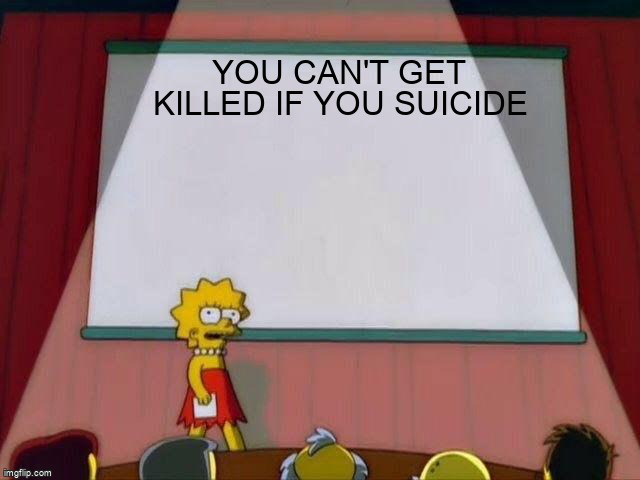

In [156]:
s= """you can't get killed if you suicide"""
if "\n" in s:
    list_s = s.split("\n", 2)
else:
    list_s = []
    list_s.append(s)
    list_s.append(" ")
s = " ".join(list_s)
test1 = tokenizer(s, padding='max_length', max_length = 256, truncation=True, return_tensors="pt")
att = test1["attention_mask"].to(device=device)
inp = test1["input_ids"].squeeze(1).to(device=device)
model.eval()
score = model(inp,att)
_, prediction = score.max(1)
print(prediction, score)
id = [148909805 ,155067746, 170715647, 101440, 1366993,10073469, 259237855, 139917843, 89370399]
username = "AmrSheta"
password = "amr1131919"
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36"
URL = 'https://api.imgflip.com/caption_image'
params = {
    'username':username,
    'password':password,
    'template_id':id[int(prediction)],
    'text0':list_s[0],
    'text1':list_s[1],
    "max_font_size": 25
}
response = requests.request('POST',URL,params=params).json()
img_data = response["data"]
img_url = img_data["url"]
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
img


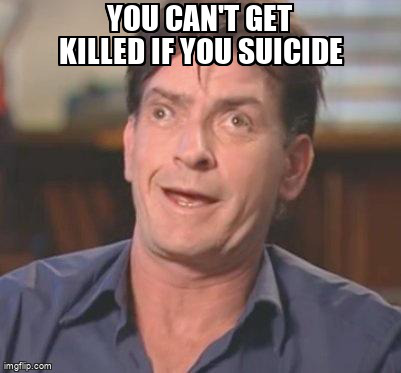

In [1]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)

NameError: name 'tokenizer' is not defined